In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import yaml
import open3d as o3d
from tqdm.notebook import tqdm

# Add the project directory to the Python path
sys.path.append('..')

# Import project modules
from src.preprocessing.image_loader import load_image_sequence, resize_images
from src.preprocessing.image_preprocessing import enhance_contrast
from src.feature_extraction.sift_extractor import extract_features_from_image_set
from src.feature_extraction.orb_extractor import extract_distributed_orb_features, extract_orb_features
from src.feature_extraction.feature_matcher import match_image_pairs, geometric_verification
from src.sfm.camera_calibration import estimate_camera_matrix
from src.sfm.pose_estimation import estimate_poses_incremental, force_loop_closure
from src.sfm.triangulation import triangulate_all_points, merge_triangulated_points
from src.sfm.bundle_adjustment import run_global_ba
from src.dense_reconstruction.mvs import process_mvs
from src.dense_reconstruction.point_cloud import process_dense_reconstruction, create_surface_mesh, save_mesh
from src.surface_reconstruction.mesh_generation import process_point_cloud_to_mesh, clean_mesh
from src.surface_reconstruction.texture_mapping import create_textured_mesh_from_point_cloud


from src.visualization.plot_matches import plot_matches, plot_feature_matching_analysis
from src.visualization.point_cloud_visualizer import plot_interactive_point_cloud, create_point_cloud_animation
from src.visualization.camera_visualizer import plot_interactive_camera_poses
from src.visualization.mesh_visualizer import visualize_mesh_o3d, plot_interactive_mesh

# Set up matplotlib for inline display
%matplotlib inline
# For newer matplotlib versions (3.6+)
plt.style.use('default')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Define configuration
config = {
    'preprocessing': {
        'resize_max_dimension': 1000,    # Higher: better detail but slower processing; Lower: faster but less detail
        'enhance_contrast': True         # True: improves feature detection in low-contrast areas; False: keeps original lighting
    },
    'features': {
        'method': 'sift',                # 'sift': more robust but slower, 'surf': faster but less accurate, 'orb': fastest but least robust
        'max_features': 50000,           # Higher: more potential matches but slower; Lower: faster but might miss details
        'use_multiscale': True,          # True: better handles scale variations but slower; False: faster but may miss features at different scales
        'use_dense': True,               # True: adds regularly spaced features (good for textureless areas); False: only interest points
        'dense_step': 5,                # Lower: more dense features (good for regular patterns); Higher: fewer features but faster
        'contrast_threshold': 0.01,      # Lower: detects more features in low-contrast areas; Higher: only strongest features
        'edge_threshold': 8             # Lower: rejects more edge-like features; Higher: keeps more features near edges
    },
    'matching': {
        'ratio_threshold': 0.7,         # Lower: stricter filtering (fewer but better matches); Higher: more matches but potential outliers
        'geometric_verification': True,  # True: essential for accurate reconstruction; False: faster but error-prone
        'min_matches': 16,               # Higher: requires stronger image connections; Lower: enables matching of dissimilar views
        'verification_method': 'fundamental', # 'fundamental': general motion; 'homography': for planar scenes or pure rotation
        'ransac_threshold': 2.0,         # Lower: stricter geometric consistency; Higher: accommodates larger calibration errors
        'cross_check': True,             # True: ensures mutual best matches only; False: more matches but lower quality
        'max_epipolar_error': 1.0,       # Lower: stricter epipolar constraint; Higher: accommodates larger calibration errors
        'confidence': 0.999              # Higher: more iterations for robust estimation; Lower: faster but less reliable
    },
    'calibration': {
        'focal_length_factor': 1.3,      # Higher: assumes narrower field of view; Lower: assumes wider angle lens
        'principal_point': 'center',     # 'center': simplest assumption; 'estimate': more accurate but needs good initialization
        'refine_intrinsics': True        # True: optimizes camera parameters; False: keeps initial estimates
    },
    'sfm': {
        'incremental': True,             # True: more robust but slower; False: faster but requires good initialization
        'refine_poses': True,            # True: improves accuracy; False: faster but less accurate
        'min_triangulation_angle_deg': 3.0, # Higher: better depth accuracy but fewer points; Lower: more points but potential noise
        'reprojection_error_threshold': 2.0, # Lower: stricter filtering of triangulated points; Higher: more points but potential outliers
        'bundle_adjustment_max_iterations': 100 # Higher: more optimization but diminishing returns; Lower: faster but less refined
    },
    'mvs': {
        'min_disparity': 0,              # Lower: captures closer objects; Higher: focuses on more distant parts of scene
        'num_disparities': 128,          # Higher: wider depth range but more memory; Lower: faster but limited depth range
        'block_size': 7,                 # Higher: smoother but less detail; Lower: more detail but potentially noisier
        'filter_depths': True,           # True: removes outliers; False: keeps all depth estimates
        'consistency_threshold': 0.01,   # Lower: stricter consistency check; Higher: more points but potential errors
        'num_source_views': 5            # Higher: more robust depth but slower; Lower: faster but potentially less accurate
    },
    'point_cloud': {
        'voxel_size': 0.02,              # Lower: preserves more detail; Higher: stronger downsampling and noise reduction
        'nb_neighbors': 30,              # Higher: better normal estimation but slower; Lower: faster but less accurate normals
        'std_ratio': 1.5,                # Lower: more aggressive outlier rejection; Higher: keeps more points including potential outliers
        'confidence_threshold': 0.8      # Higher: keeps only high-confidence points; Lower: more points but potential noise
    },
    'surface': {
        'method': 'poisson',             # 'poisson': smooth watertight mesh; 'ball_pivoting': faster but holes; 'alpha_shape': better for incomplete scans
        'depth': 10,                     # Higher: captures finer details but may introduce artifacts; Lower: smoother but less detail
        'cleanup': True,                 # True: removes isolated components; False: keeps all geometry
        'trim': 7.0                      # Higher: more aggressive trimming of uncertain areas; Lower: more complete but potentially noisier
    },
    'visualization': {
        'point_size': 2,                 # Higher: easier to see sparse points; Lower: better for dense reconstructions
        'camera_size': 6,                # Higher: more visible camera positions; Lower: less obtrusive
        'point_color_method': 'rgb'      # 'rgb': original colors; 'depth': depth visualization; 'normal': surface orientation
    }
}

# Create output directory for results
output_dir = "../data/results/"
os.makedirs(output_dir, exist_ok=True)

print("Configuration loaded with 50,000 maximum features and strict quality filtering.")

Configuration loaded with 50,000 maximum features and strict quality filtering.


Loading black background images for feature extraction...
Loaded 36 black background images.
Loading original background images for depth estimation...
Loaded 36 original background images.
Resized images to maximum dimension of 1000 pixels.
Enhanced image contrast.


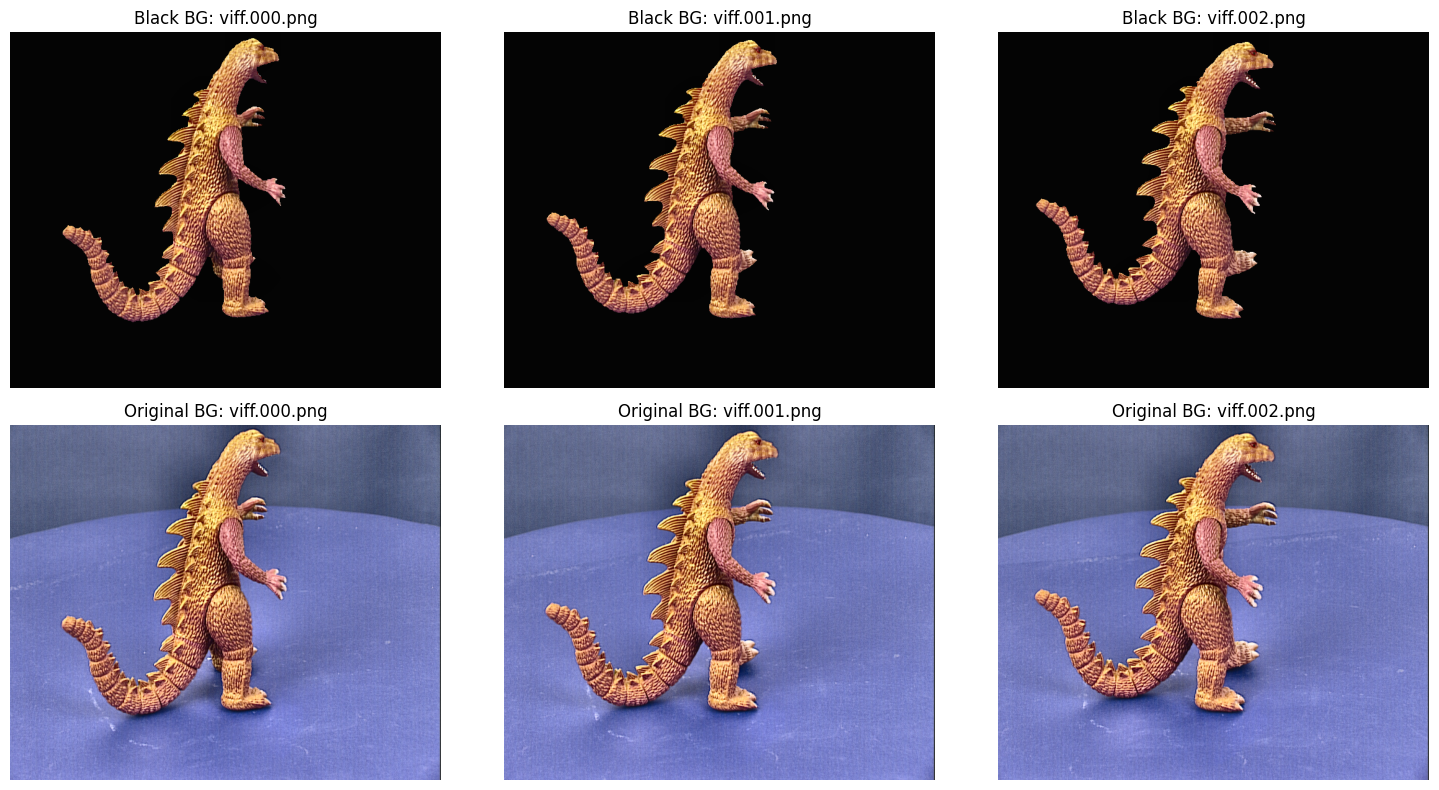

In [3]:
# Define paths to both datasets
dataset_path_black = '../data/dinosaur_cropped_black/'  # Black background
dataset_path_original = '../data/dinosaur_cropped/'       # Original background

# Load black background images for feature extraction and matching
print("Loading black background images for feature extraction...")
black_images = load_image_sequence(dataset_path_black, pattern="viff.*.png")
print(f"Loaded {len(black_images)} black background images.")

# Also load original background images for depth estimation
print("Loading original background images for depth estimation...")
original_images = load_image_sequence(dataset_path_original, pattern="viff.*.png")
print(f"Loaded {len(original_images)} original background images.")

# Make sure image lists are the same length and in the same order
if len(black_images) != len(original_images):
    print("Warning: Different number of images in the two datasets")
    # Keep only matching filenames
    black_filenames = [filename for _, filename in black_images]
    original_filenames = [filename for _, filename in original_images]
    common_filenames = set(black_filenames).intersection(set(original_filenames))
    
    black_images = [(img, filename) for img, filename in black_images if filename in common_filenames]
    original_images = [(img, filename) for img, filename in original_images if filename in common_filenames]
    
    print(f"Using {len(black_images)} images that exist in both datasets")

# Resize black background images
max_dim = config['preprocessing']['resize_max_dimension']
black_images = resize_images(black_images, max_dimension=max_dim)
original_images = resize_images(original_images, max_dimension=max_dim)
print(f"Resized images to maximum dimension of {max_dim} pixels.")

# Enhance contrast if specified
if config['preprocessing']['enhance_contrast']:
    black_images = enhance_contrast(black_images)
    original_images = enhance_contrast(original_images)
    print("Enhanced image contrast.")

# Display a comparison between black and original images
n_images = min(3, len(black_images))
fig, axes = plt.subplots(2, n_images, figsize=(15, 8))

for i in range(n_images):
    img_black, filename_black = black_images[i]
    axes[0, i].imshow(img_black)
    axes[0, i].set_title(f"Black BG: {filename_black}")
    axes[0, i].axis('off')
    
    img_orig, filename_orig = original_images[i]
    axes[1, i].imshow(img_orig)
    axes[1, i].set_title(f"Original BG: {filename_orig}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


Extracting comprehensive features from black background images...
Using enhanced SIFT extraction with target of 50000 features per image
viff.000.png: Extracted 15711 keypoints
viff.001.png: Extracted 15744 keypoints
viff.002.png: Extracted 16019 keypoints
viff.003.png: Extracted 16255 keypoints
viff.004.png: Extracted 15950 keypoints
viff.005.png: Extracted 15249 keypoints
viff.006.png: Extracted 14712 keypoints
viff.007.png: Extracted 13874 keypoints
viff.008.png: Extracted 13353 keypoints
viff.009.png: Extracted 12584 keypoints
viff.010.png: Extracted 11703 keypoints
viff.011.png: Extracted 11499 keypoints
viff.012.png: Extracted 11519 keypoints
viff.013.png: Extracted 11284 keypoints
viff.014.png: Extracted 11190 keypoints
viff.015.png: Extracted 11959 keypoints
viff.016.png: Extracted 12506 keypoints
viff.017.png: Extracted 13817 keypoints
viff.018.png: Extracted 14711 keypoints
viff.019.png: Extracted 15220 keypoints
viff.020.png: Extracted 15355 keypoints
viff.021.png: Extracte

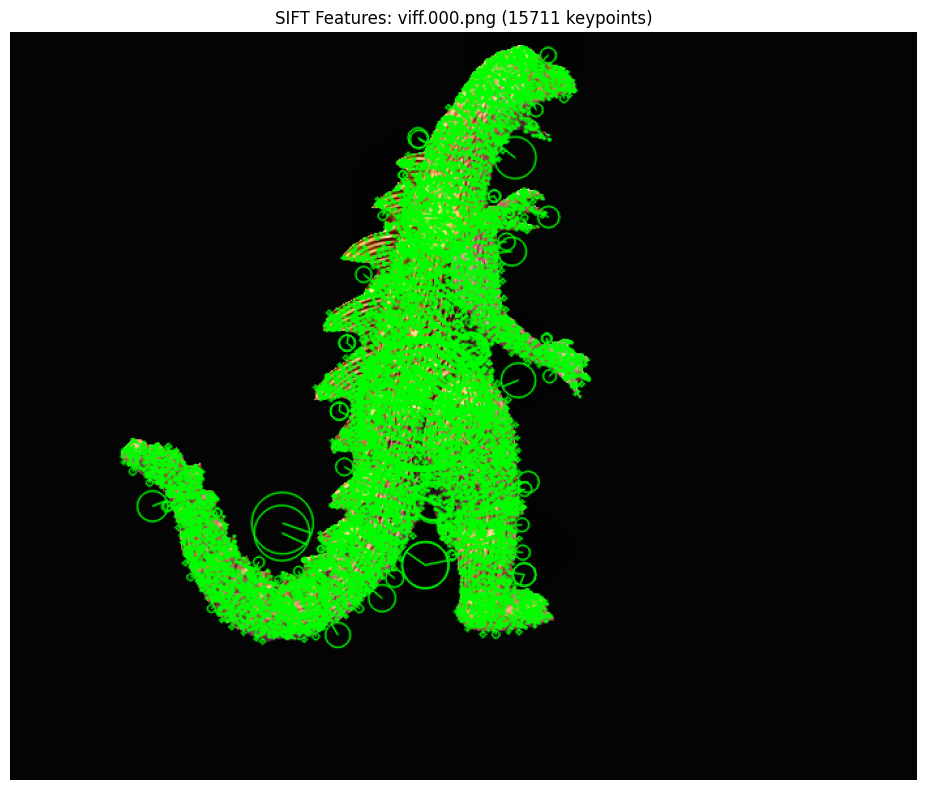


Creating optimized view graph for circular object reconstruction...
Creating view graph for 36 images
Created 36 image pairs for matching
Successfully matched 36 image pairs.


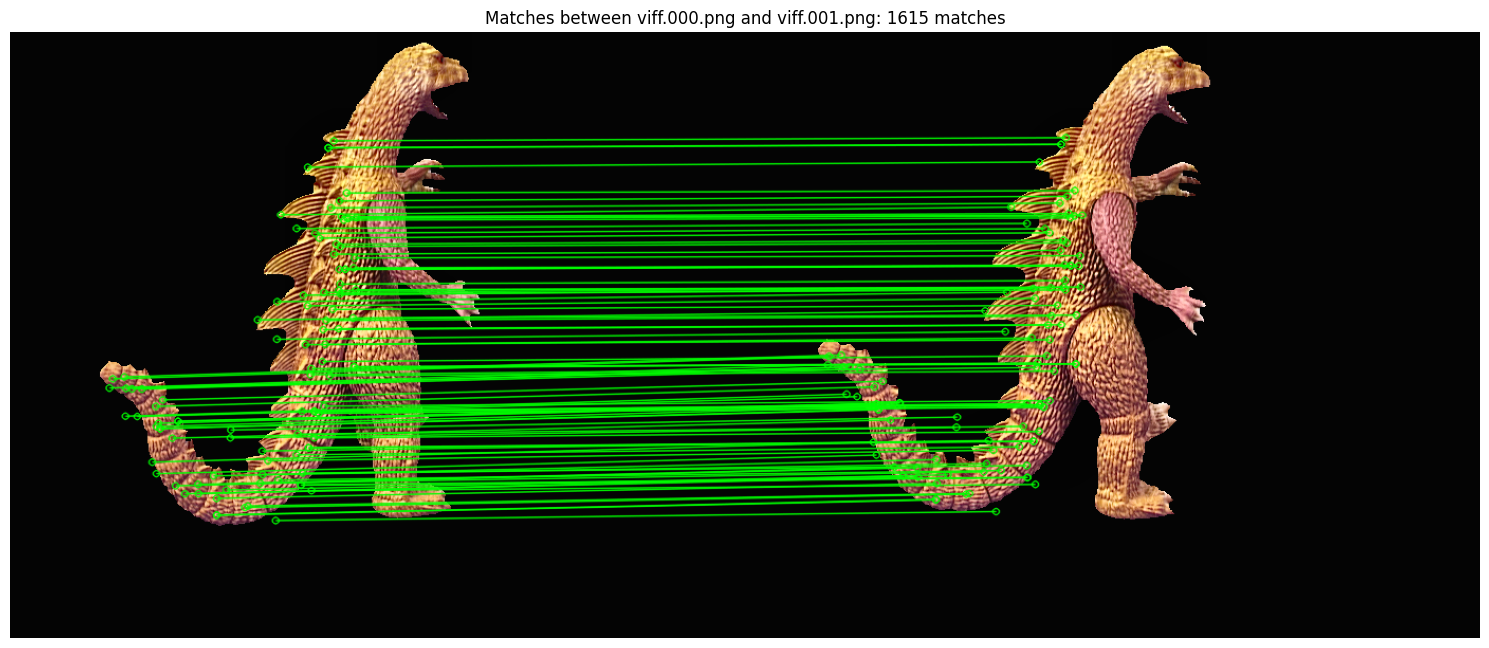

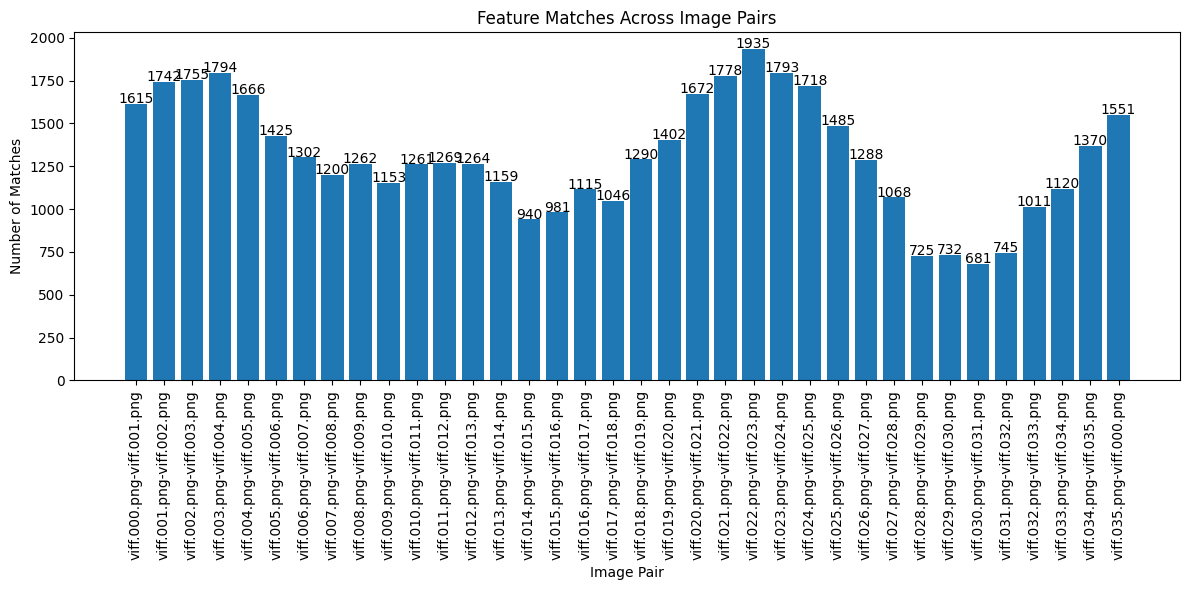

In [4]:
# Extract features from black background images with enhanced strategies
print("\nExtracting comprehensive features from black background images...")
feature_method = config['features']['method']
max_features = config['features']['max_features']  # Triple the feature count

# Set SIFT extraction parameters if using SIFT
if feature_method.lower() == 'sift':
    print(f"Using enhanced SIFT extraction with target of {max_features} features per image")
    
    # Extract features using enhanced extraction methods
    features_dict = extract_features_from_image_set(black_images, method=feature_method, n_features=max_features)
else:
    # For other methods, use standard extraction
    features_dict = extract_features_from_image_set(black_images, method=feature_method, n_features=max_features)

# Print feature counts
total_features = 0
for filename, (keypoints, descriptors) in features_dict.items():
    print(f"{filename}: {len(keypoints)} keypoints")
    total_features += len(keypoints)

print(f"Total features extracted: {total_features} (avg {total_features/len(features_dict):.0f} per image)")

# Visualize keypoints on a sample image
sample_img, sample_filename = black_images[0]
sample_keypoints, _ = features_dict[sample_filename]

# Plot keypoints
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.drawKeypoints(sample_img, sample_keypoints, None, 
                          color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax.set_title(f"{feature_method.upper()} Features: {sample_filename} ({len(sample_keypoints)} keypoints)")
ax.axis('off')
plt.tight_layout()
plt.show()

# Create image pairs for matching with a comprehensive circular strategy
print("\nCreating optimized view graph for circular object reconstruction...")
filenames = sorted([filename for _, filename in black_images], 
                  key=lambda x: int(''.join(filter(str.isdigit, x))))

# Number of images
n = len(filenames)
print(f"Creating view graph for {n} images")

# Create image pairs for matching with a comprehensive circular strategy
image_pairs = []

# 1. Keep sequential pairs as your foundation
for i in range(n-1):
    image_pairs.append((filenames[i], filenames[i+1]))
image_pairs.append((filenames[-1], filenames[0]))  # Close the loop
# Remove duplicates while preserving order
seen = set()
image_pairs = [x for x in image_pairs if not (x in seen or seen.add(x))]

print(f"Created {len(image_pairs)} image pairs for matching")

# Match features
matches_dict = match_image_pairs(
    features_dict, 
    image_pairs, 
    ratio_threshold=config['matching']['ratio_threshold'],
    geometric_verify=config['matching']['geometric_verification'],
    min_matches=config['matching']['min_matches']
)

print(f"Successfully matched {len(matches_dict)} image pairs.")

# Display matches for a sample pair
if len(matches_dict) > 0:
    # Choose a sample pair
    sample_pair = list(matches_dict.keys())[0]
    img1_name, img2_name = sample_pair
    kp1, kp2, matches = matches_dict[sample_pair]
    
    # Get the images
    img1 = next(img for img, filename in black_images if filename == img1_name)
    img2 = next(img for img, filename in black_images if filename == img2_name)
    
    # Plot matches
    plot_matches(img1, kp1, img2, kp2, matches[:100],  # Only plot first 100 matches for clarity
                title=f"Matches between {img1_name} and {img2_name}: {len(matches)} matches")

    # Show matching statistics across all pairs
    plot_feature_matching_analysis(matches_dict, figsize=(12, 6))

In [5]:
# Estimate camera intrinsics
print("\nEstimating camera intrinsics...")
sample_img, _ = black_images[0]
image_shape = sample_img.shape
focal_length_factor = config['calibration']['focal_length_factor']
focal_length = focal_length_factor * max(image_shape[0], image_shape[1])
K = estimate_camera_matrix(image_shape, focal_length)

print("Estimated camera matrix:")
print(K)

# Estimate camera poses using incremental SfM
print("\nEstimating camera poses using Structure from Motion...")
camera_poses = estimate_poses_incremental(matches_dict, K, config['matching']['min_matches'])

print(f"Estimated poses for {len(camera_poses)} cameras.")

# Visualize camera poses
if len(camera_poses) > 0:
    # Extract camera positions for visualization (camera center is -R^T * t)
    camera_positions = {name: -R.T @ t for name, (R, t) in camera_poses.items()}
    
    # Plot camera positions
    plot_interactive_camera_poses(camera_poses)


Estimating camera intrinsics...
Estimated camera matrix:
[[903.5   0.  347.5]
 [  0.  903.5 286.5]
 [  0.    0.    1. ]]

Estimating camera poses using Structure from Motion...
Initializing with pair: viff.000.png and viff.001.png (1615 matches)
Triangulated 1615 initial points
Attempting to add image: viff.002.png
Found 166 2D-3D correspondences for viff.002.png
PnP successful with 86 inliers. Mean reprojection error: 0.39 pixels
Added pose for viff.002.png using 86 / 166 points
  Triangulated 918 new points with viff.001.png and viff.002.png
Attempting to add image: viff.003.png
Found 172 2D-3D correspondences for viff.003.png
PnP successful with 82 inliers. Mean reprojection error: 0.36 pixels
Added pose for viff.003.png using 82 / 172 points
  Triangulated 892 new points with viff.002.png and viff.003.png
Attempting to add image: viff.004.png
Found 179 2D-3D correspondences for viff.004.png
PnP successful with 84 inliers. Mean reprojection error: 0.40 pixels
Added pose for viff.00

In [ ]:
# Triangulate 3D points
print("\nTriangulating 3D points...")
points_3d, point_observations = triangulate_all_points(camera_poses, matches_dict, K)

print(f"Triangulated {len(points_3d)} 3D points.")

# Merge close points to reduce noise
merged_points, merged_observations = merge_triangulated_points(points_3d, point_observations, threshold=0.002)
print(f"After merging: {len(merged_points)} 3D points.")

# Bundle adjustment to refine camera poses and 3D points
if config['sfm']['refine_poses'] and len(merged_points) > 0:
    print("\nRunning bundle adjustment...")
    refined_poses, refined_points, _ = run_global_ba(camera_poses, matches_dict, K, iterations=50)
    camera_poses = refined_poses
    points_3d = refined_points
    print("Bundle adjustment complete.")

plot_interactive_camera_poses(camera_poses)

# Visualize sparse point cloud
if len(points_3d) > 0:
    print("\nVisualizing sparse point cloud...")
    points_array = np.array(points_3d)
    
    # Assign random colors for visualization
    np.random.seed(42)  # For reproducibility
    colors = np.random.rand(len(points_array), 3)
    
    # Interactive visualization
    plot_interactive_point_cloud(points_array, colors, title="Sparse 3D Reconstruction")

    # Save sparse point cloud
    sparse_cloud_file = os.path.join(output_dir, "dinosaur_sparse.ply")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_array)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(sparse_cloud_file, pcd)
    print(f"Saved sparse point cloud to {sparse_cloud_file}")


Triangulating 3D points...
Triangulating from 36 camera poses and 36 feature matches
Found 36 valid image pairs for triangulation
Triangulated 46979 3D points
Triangulated 46979 3D points.
Merged 46979 points into 36477 points
After merging: 36477 3D points.

Running bundle adjustment...
Triangulating from 36 camera poses and 36 feature matches
Found 36 valid image pairs for triangulation
Triangulated 46979 3D points
Merged 46979 points into 37136 points
Prepared 37136 points with at least 2 observations for bundle adjustment
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1196e+04                                    2.34e+05    
       1              4         1.0215e+04      9.81e+02       9.11e+00       1.84e+05    
       2              5         7.6081e+03      2.61e+03       1.48e+01       6.02e+05    
       3              6         4.3540e+03      3.25e+03       4.30e+00       5.17e+04    
       4    

In [ ]:
# Significantly modified MVS configuration optimized for challenging objects like dinosaur figurines
improved_mvs_config = {
    'min_disparity': 0,
    'num_disparities': 192,      # Increased for better depth range coverage
    'block_size': 13,            # Larger block for smooth surfaces
    'filter_depths': True,
    'consistency_threshold': 0.18, # Much more permissive threshold for challenging textures
    'num_source_views': 6,       # Use more source views
    'speckle_size': 150,         # Increased speckle filtering
    'speckle_range': 3,          # Slightly increased range
    'uniqueness_ratio': 5,       # Lower ratio to capture more potential matches
    'pre_filter_cap': 31
}

# Run MVS with improved parameters using hybrid approach - both clean and original images
print("\nRunning Multi-View Stereo with hybrid approach...")

# Create hybrid image list that combines black background and original images
hybrid_images = []
for name in camera_poses.keys():
    # First find the original background image
    orig_img = next((img for img, filename in original_images if filename == name), None)
    # Also find the black background image
    black_img = next((img for img, filename in black_images if filename == name), None)
    
    if orig_img is not None and black_img is not None:
        # Create a mask from the black background image
        if len(black_img.shape) == 3:
            gray = cv2.cvtColor(black_img, cv2.COLOR_RGB2GRAY)
        else:
            gray = black_img
        
        # Create binary mask (non-black areas)
        _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
        
        # Add preprocessing to enhance texture
        # Apply CLAHE to original image to enhance texture
        if len(orig_img.shape) == 3:
            lab = cv2.cvtColor(orig_img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            enhanced_lab = cv2.merge((cl, a, b))
            enhanced_orig = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
        else:
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            enhanced_orig = clahe.apply(orig_img)
        
        # Use the original image (with texture enhancement) for MVS
        hybrid_images.append((enhanced_orig, name))
    elif orig_img is not None:
        # Fall back to original if no black background version exists
        hybrid_images.append((orig_img, name))
    elif black_img is not None:
        # Fall back to black background if no original version exists
        hybrid_images.append((black_img, name))

mvs_results = process_mvs(hybrid_images, camera_poses, K, config['mvs'])

# Extract depth maps
depth_maps = mvs_results['filtered_depth_maps']
confidence_maps = mvs_results['confidence_maps']

print(f"Generated {len(depth_maps)} depth maps.")

# Apply additional post-processing to improve depth maps
print("Applying additional depth map enhancement...")
enhanced_depth_maps = {}

for name, depth_map in depth_maps.items():
    # Find valid depths
    valid_mask = depth_map > 0
    
    if np.sum(valid_mask) > 0:
        # Apply median filter to remove noise (with larger kernel)
        filtered_depth = cv2.medianBlur(depth_map, 5)
        
        # Fill small holes using morphological operations
        kernel = np.ones((5, 5), np.uint8)
        valid_mask_filled = cv2.morphologyEx(valid_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        
        # Use a more aggressive bilateral filter to smooth while preserving edges
        smoothed_depth = cv2.bilateralFilter(filtered_depth, 9, 75, 75)
        
        # Combine the results
        enhanced_depth = smoothed_depth.copy()
        
        # Keep only the valid regions after morphological operations
        enhanced_depth[valid_mask_filled == 0] = 0
        
        enhanced_depth_maps[name] = enhanced_depth
    else:
        enhanced_depth_maps[name] = depth_map

# Replace the original depth maps with enhanced ones
depth_maps = enhanced_depth_maps

# Visualize a sample depth map
if len(depth_maps) > 0:
    # Choose a sample depth map
    sample_name = list(depth_maps.keys())[0]
    depth_map = depth_maps[sample_name]
    
    # Normalize depth for visualization
    valid_mask = depth_map > 0
    if np.any(valid_mask):
        min_depth = np.min(depth_map[valid_mask])
        max_depth = np.max(depth_map[valid_mask])
        normalized_depth = np.zeros_like(depth_map)
        normalized_depth[valid_mask] = (depth_map[valid_mask] - min_depth) / (max_depth - min_depth)
        
        # Display depth map with improved color mapping
        plt.figure(figsize=(10, 8))
        plt.imshow(normalized_depth, cmap='turbo')  # Using turbo colormap for better depth visualization
        plt.colorbar(label='Normalized Depth')
        plt.title(f"Enhanced Depth Map: {sample_name}")
        plt.axis('off')
        plt.show()
        
        # Also show the confidence map
        conf_map = confidence_maps[sample_name]
        plt.figure(figsize=(10, 8))
        plt.imshow(conf_map, cmap='viridis')
        plt.colorbar(label='Confidence')
        plt.title(f"Confidence Map: {sample_name}")
        plt.axis('off')
        plt.show()

# Enhanced point cloud settings specifically for challenging objects like dinosaur models
enhanced_point_cloud_config = {
    'voxel_size': 0.02,           # Smaller voxel size for more detail
    'nb_neighbors': 30,           # More neighbors for better outlier detection
    'std_ratio': 2.5,             # More permissive outlier rejection
    'confidence_threshold': 0.3    # Lower threshold to include more points
}

# Generate dense point cloud with size limits
print("\nGenerating dense point cloud from depth maps...")
dense_results = process_dense_reconstruction(
    hybrid_images, camera_poses, K, depth_maps, confidence_maps, enhanced_point_cloud_config)

# Extract results
dense_points = dense_results['filtered_points']
dense_colors = dense_results['filtered_colors']

# Limit point cloud size if needed
if len(dense_points) > 500000:
    print(f"Point cloud too large ({len(dense_points)} points), downsampling to ~500K points...")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(dense_points)
    pcd.colors = o3d.utility.Vector3dVector(dense_colors)
    
    # Gradually increase voxel size until points are under 500K
    target_size = 500000
    voxel_size = 0.025
    while len(pcd.points) > target_size and voxel_size < 0.1:
        voxel_size += 0.01
        pcd = pcd.voxel_down_sample(voxel_size)
        print(f"Downsampled to {len(pcd.points)} points with voxel size {voxel_size:.2f}")
    
    dense_points = np.asarray(pcd.points)
    dense_colors = np.asarray(pcd.colors)

if len(dense_points) > 0:
    print(f"Final point cloud contains {len(dense_points)} points.")
    
    # Visualize dense point cloud
    plot_interactive_point_cloud(dense_points, dense_colors, title="Dense 3D Reconstruction")
    
    # Save dense point cloud
    dense_cloud_file = os.path.join(output_dir, "dinosaur_dense.ply")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(dense_points)
    pcd.colors = o3d.utility.Vector3dVector(dense_colors)
    o3d.io.write_point_cloud(dense_cloud_file, pcd)
    print(f"Saved dense point cloud to {dense_cloud_file}")
    
    # Create mesh with optimized parameters for dinosaur model
    mesh_config = {
        'method': 'poisson',
        'depth': 9,             # Higher depth for more detail
        'scale': 1.1,           # Slightly aggressive weighing
        'cleanup': True
    }
    
    print("\nCreating mesh from point cloud...")
    # Compute normals with better parameters
    print("Computing normals with optimized parameters...")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(dense_points)
    pcd.colors = o3d.utility.Vector3dVector(dense_colors)
    
    # Use more neighbors for smoother normals on the dinosaur surface
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    pcd.orient_normals_consistent_tangent_plane(k=20)
    
    normals = np.asarray(pcd.normals)
    
    # Create mesh
    mesh = create_surface_mesh(
        dense_points, 
        dense_colors, 
        normals,
        method=mesh_config['method'], 
        depth=mesh_config['depth']
    )
    
    if mesh:
        # Clean the mesh
        print("Cleaning mesh to improve quality...")
        mesh = clean_mesh(mesh, detail_level=3)
        
        # Optional: apply Laplacian smoothing to get smoother dinosaur surface
        print("Applying final smoothing to improve surface quality...")
        mesh = mesh.filter_smooth_taubin(number_of_iterations=10)
        
        # Save the mesh
        mesh_file = os.path.join(output_dir, "dinosaur_mesh.ply")
        save_mesh(mesh, mesh_file)
        print(f"Saved mesh to {mesh_file}")
        
        # Visualize the mesh
        visualize_mesh_o3d(mesh, window_name="Dinosaur 3D Mesh")

In [ ]:
# Generate mesh from dense point cloud
print("\nGenerating surface mesh...")
mesh, pcd = process_point_cloud_to_mesh(
    dense_points, dense_colors, method=config['surface']['method'])

# Display mesh statistics
print(f"Mesh contains {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles.")

# Visualize mesh (this will open an Open3D window)
print("\nVisualizing mesh (this will open a new window)...")
visualize_mesh_o3d(mesh, window_name="Reconstructed Mesh")

# Save mesh
mesh_file = os.path.join(output_dir, "dinosaur_mesh.ply")
o3d.io.write_triangle_mesh(mesh_file, mesh)
print(f"Saved mesh to {mesh_file}")

In [ ]:
# Generate textured mesh
print("\nGenerating textured mesh...")
textured_mesh = create_textured_mesh_from_point_cloud(
    dense_points, dense_colors, images, camera_poses, K, 
    reconstruction_method=config['surface']['method'])

# Visualize textured mesh (this will open an Open3D window)
print("\nVisualizing textured mesh (this will open a new window)...")
visualize_mesh_o3d(textured_mesh, window_name="Textured Mesh")

# Save textured mesh
textured_mesh_file = os.path.join(output_dir, "dinosaur_textured.obj")
o3d.io.write_triangle_mesh(textured_mesh_file, textured_mesh)
print(f"Saved textured mesh to {textured_mesh_file}")

In [ ]:
# Create interactive mesh visualization using Plotly
print("\nCreating interactive mesh visualization...")

# Extract mesh data for Plotly
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)
vertex_colors = np.asarray(mesh.vertex_colors) if mesh.has_vertex_colors() else None

# Create interactive plot
plot_interactive_mesh(vertices, triangles, vertex_colors, title="Interactive 3D Dinosaur Model")

# Create rotating animation (optional)
print("\nCreating 360° animation of the model...")
animation = create_point_cloud_animation(
    dense_points, dense_colors, n_frames=36, 
    output_file=os.path.join(output_dir, "dinosaur_animation.html"))

print("\n3D reconstruction pipeline complete!")
print(f"All results saved to: {output_dir}")

# Display summary of the reconstruction
print("\nReconstruction Summary:")
print(f"Images processed: {len(images)}")
print(f"Camera poses estimated: {len(camera_poses)}")
print(f"Sparse points: {len(points_3d)}")
print(f"Dense points: {len(dense_points)}")
print(f"Mesh vertices: {len(mesh.vertices)}")
print(f"Mesh triangles: {len(mesh.triangles)}")

In [ ]:
# Simplify and optimize mesh for 3D printing (optional)
print("\nOptimizing mesh for export...")

# Make a copy of the mesh for optimization
export_mesh = o3d.geometry.TriangleMesh(mesh)

# Remove any non-manifold edges
export_mesh.remove_non_manifold_edges()

# Fill holes
export_mesh = export_mesh.filter_smooth_simple(5)  # Smooth mesh

# Simplify mesh to reduce polygon count
target_triangles = int(len(export_mesh.triangles) * 0.5)  # Reduce to 50%
export_mesh = export_mesh.simplify_quadric_decimation(target_triangles)

# Fix mesh normals
export_mesh.compute_vertex_normals()

# Save optimized mesh in multiple formats
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.obj"), export_mesh)
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.stl"), export_mesh)

print("Optimized mesh exported in OBJ and STL formats, suitable for 3D printing and other applications.")